# EDA 04 Stimulus Violation Interactions Psychometrics

**Goal**: Assess the variance of previous violation regressor for each animal and simulate psychometrics with varying filter strengths specific to each animal.

Related notebooks:

* `2024_02_19_fit_filtered_prev_violation_stim_intrx.ipynb`
* `2024_01_19_stg4_stim_viol_intrxs.ipynb`


NOTE: this notebook is just a first pass- something seems a little off with the psychometrics having such low lapse rates when the filter is off- the performance is near perfect. This is going to require some digging. Additionally, it is quite messy and many things from `2024_01_19_stg4_stim_viol_intrxs.ipynb` were copied out and modified. This notebook should be completely remade and have additional functions added in.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from multiglm.data.dataset_loader import DatasetLoader
from multiglm.experiments.experiment import load_experiment
from multiglm.data import ANIMAL_IDS
from multiglm.visualizations.model_visualizer import ModelVisualizer

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from multiglm.features.design_matrix_generator import DesignMatrixGenerator
from multiglm.utils.fitting_utils import get_taus_df


def generate_design_mat_with_filter_prev_violation(animal_ids):
    """
    function to make a design matrix for all animals
    with the prev_violation column filtered by the
    animal's prev_violation_tau that was fit to the
    animal's data
    """

    X_animals = []
    taus_df = get_taus_df()
    df = DatasetLoader(animal_ids=animal_ids, data_type="new_trained").load_data()

    for animal_id in animal_ids:
        # load df
        animal_df = df.query("animal_id == @animal_id")

        # get tau
        prev_violation_tau = taus_df.query("animal_id == @animal_id")[
            f"prev_violation_tau"
        ].values[0]

        # create design matrix with filt prev violation
        dmg = DesignMatrixGenerator()
        X = dmg.generate_base_matrix(
            animal_df, return_labels=False, include_stage=False
        )
        X = dmg.exp_filter_column(X, tau=prev_violation_tau, column="prev_violation")
        X["animal_id"] = [animal_id] * len(X)
        X["prev_violation_tau"] = [prev_violation_tau] * len(X)
        X_animals.append(X)

    prev_violation_df = pd.concat(X_animals, ignore_index=True)

    return prev_violation_df

In [14]:
filtered_prev_violation_df = generate_design_mat_with_filter_prev_violation(ANIMAL_IDS)

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [15]:
filtered_prev_violation_df = filtered_prev_violation_df.query("animal_id != 'W082'")

In [44]:
tau_palette = sns.color_palette(
    "husl", filtered_prev_violation_df.prev_violation_tau.nunique()
)

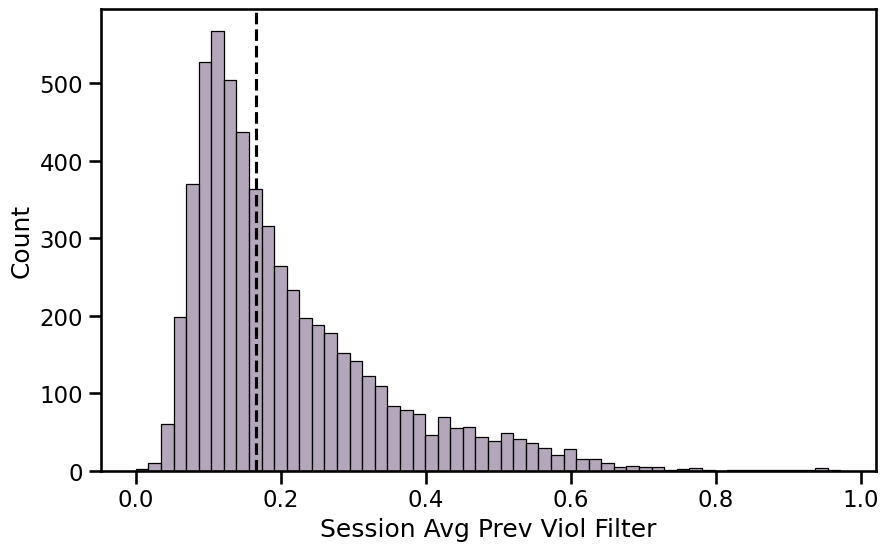

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_data = (
    filtered_prev_violation_df.groupby(["animal_id", "session"])
    .prev_violation_exp.mean()
    .reset_index()
)
sns.histplot(
    data=plot_data,
    x="prev_violation_exp",
    ax=ax,
    color="#9c8aa5",
)

ax.axvline(plot_data.prev_violation_exp.median(), color="black", linestyle="--")

_ = ax.set(xlabel="Session Avg Prev Viol Filter")

The distribution of the previous violation filter is right skewed with a median near 0.2 and most of it's density near 0.6.

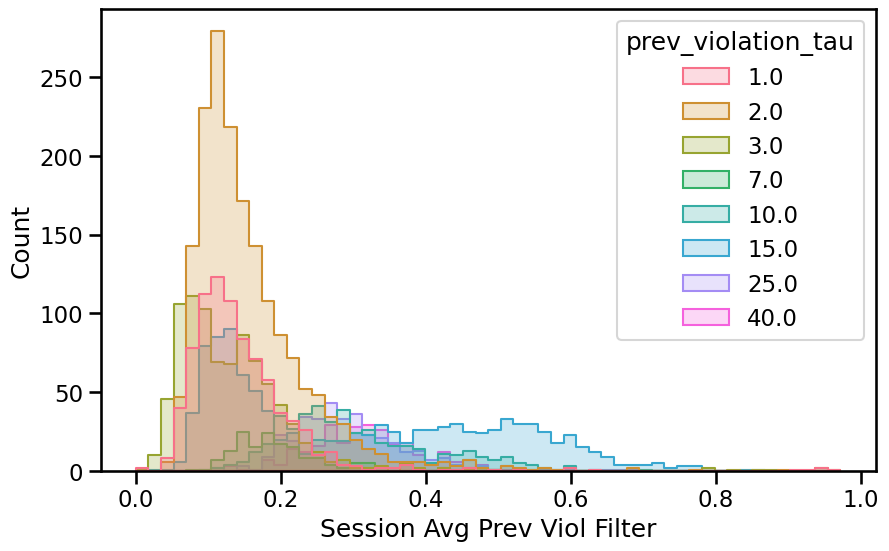

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(
    data=filtered_prev_violation_df.groupby(
        ["animal_id", "session", "prev_violation_tau"]
    )
    .prev_violation_exp.mean()
    .reset_index(),
    x="prev_violation_exp",
    hue="prev_violation_tau",
    palette=tau_palette,
    element="step",
    ax=ax,
)

_ = ax.set(xlabel="Session Avg Prev Viol Filter")

When you condition on tau, you can see that the larger the tau, the higher the median of the distribution. Meaning the filter is larger in value for longer.

In [59]:
def plot_histogram_facet_grid(
    df,
    var,
    binwidth=1,
    color=None,
    stat="count",
    **kwargs,
):
    """
    function to plot a histogram facet grid
    """
    g = sns.FacetGrid(df, col="animal_id", col_wrap=4, **kwargs)
    g.map(sns.histplot, var, binwidth=binwidth, color=color, stat=stat)

    if stat == "percent":
        g.set(ylim=(0, 100))
    return g


def plot_prev_viol_median(data, **kwargs):
    """
    function to plot a vertical line at the median
    of the prev_violation_exp column

    used with g.map_dataframe()
    """
    median = data["prev_violation_exp"].median()
    plt.axvline(median, color="k", linestyle="--")
    plt.text(
        median + 0.1,
        plt.gca().get_ylim()[1] * 0.8,
        f"{np.round(median, 2)}",
        color="k",
    )


import matplotlib.patches as mpatches


def plot_prev_viol_tau_palette(figsize=(5, 1)):
    """
    handy plot util to plot a legend of the prev_violation_tau
    for presentation visuals
    """
    taus_df = get_taus_df()
    palette = sns.color_palette("husl", n_colors=taus_df.prev_violation_tau.nunique())

    # Create a list of patches for the legend
    legend_patches = [
        mpatches.Patch(color=palette[i], label=tau)
        for i, tau in enumerate(sorted(taus_df.prev_violation_tau.unique()))
    ]

    # Plot the legend separately
    plt.figure(figsize=figsize)
    plt.legend(
        handles=legend_patches,
        title="Prev Violation Tau",
        bbox_to_anchor=(1, 1),
        loc="center",
    )
    plt.axis("off")
    plt.show()

    return None

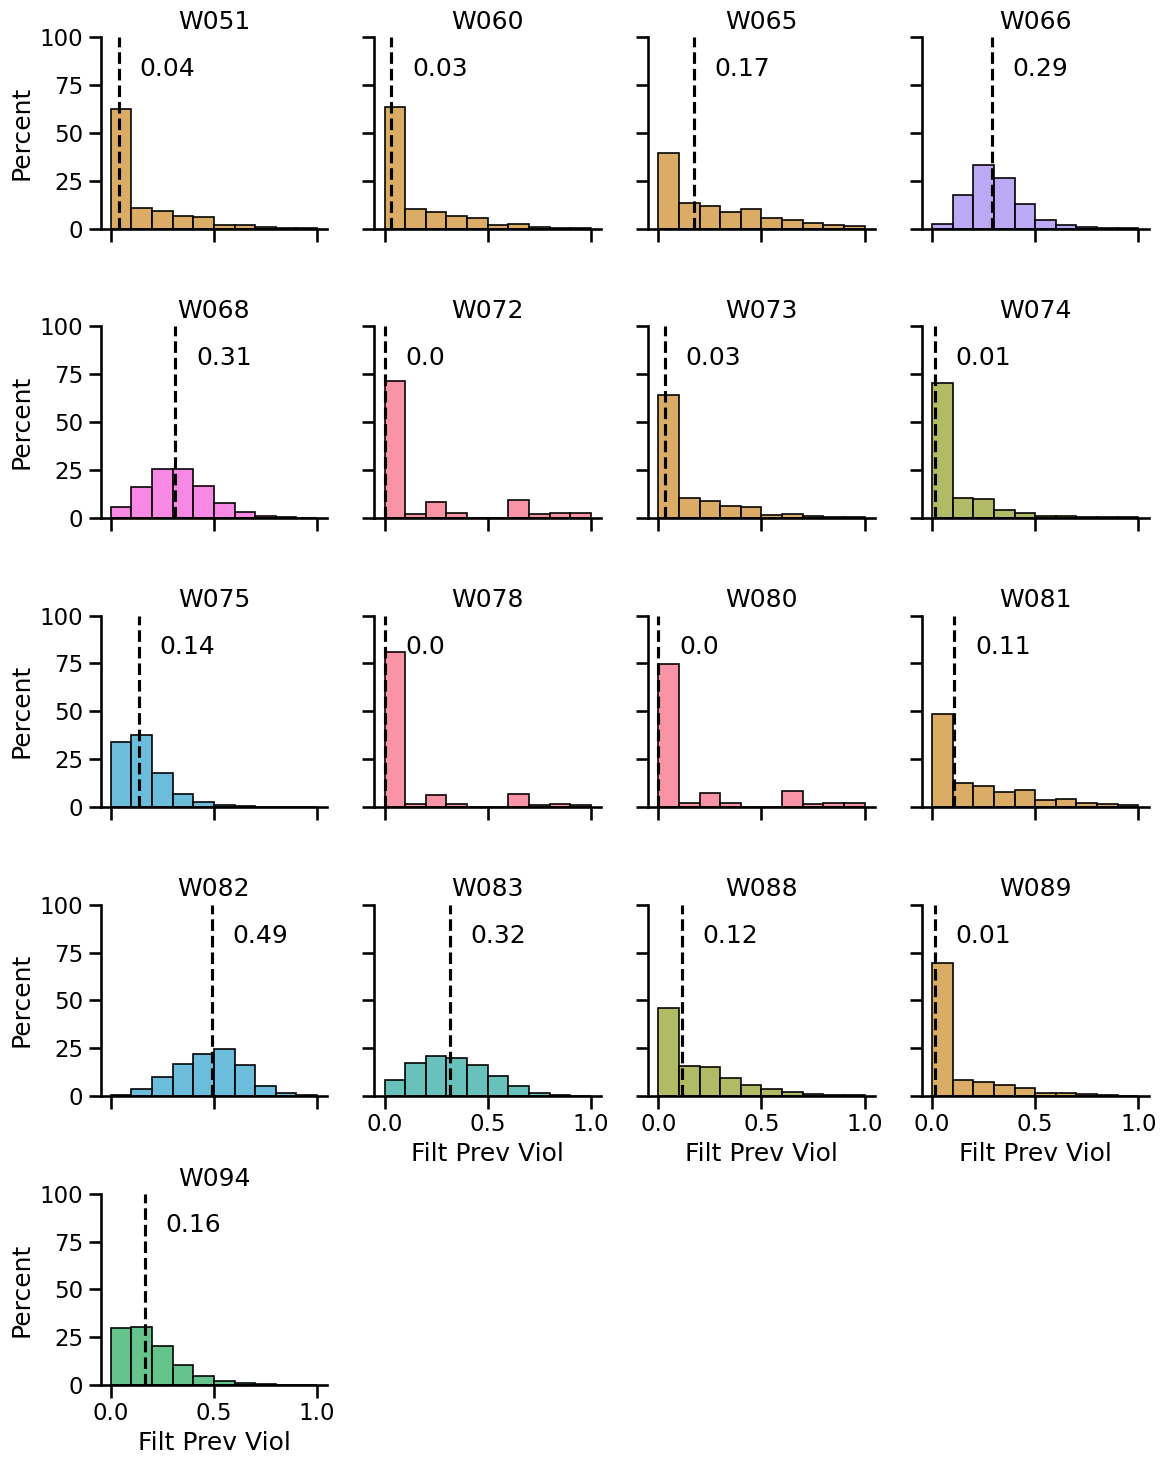

In [60]:
g = plot_histogram_facet_grid(
    filtered_prev_violation_df,
    "prev_violation_exp",
    binwidth=0.1,
    hue="prev_violation_tau",
    stat="percent",
    palette=tau_palette,
)

g.map_dataframe(plot_prev_viol_median)
g.set_axis_labels("Filt Prev Viol", "Percent")
g.set_titles("{col_name}")

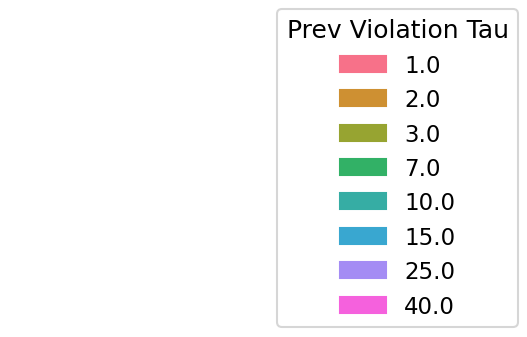

In [48]:
plot_prev_viol_tau_palette()

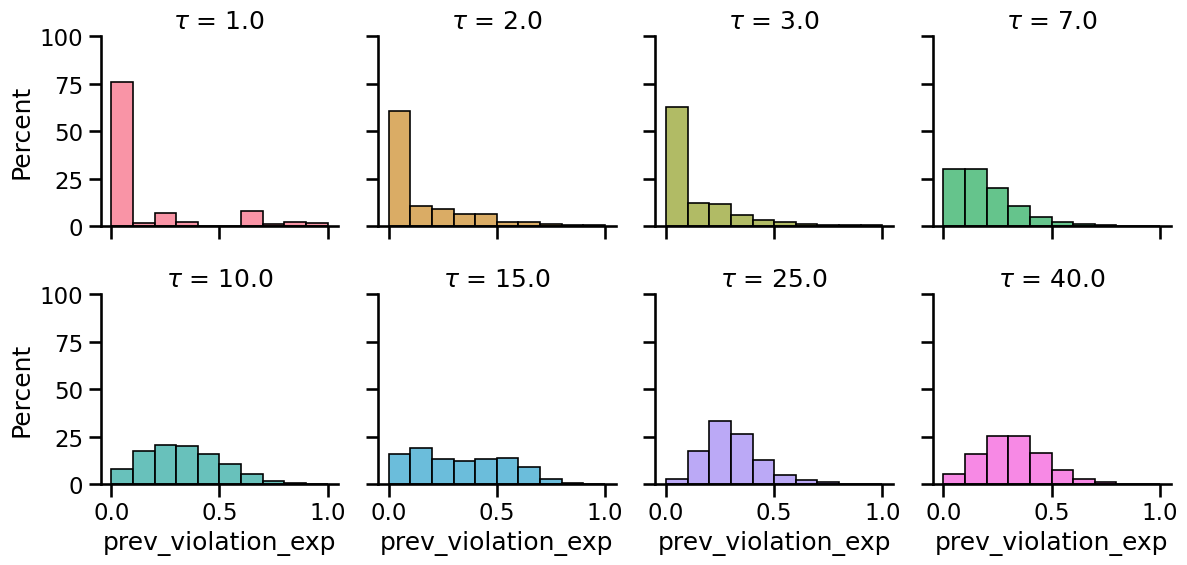

In [76]:
g = sns.FacetGrid(
    filtered_prev_violation_df,
    col="prev_violation_tau",
    col_wrap=4,
    palette=tau_palette,
    hue="prev_violation_tau",
)
g.map(sns.histplot, "prev_violation_exp", binwidth=0.1, stat="percent")
g.set_titles("$\\tau$ = {col_name}")
g.set(ylim=(0, 100))

In [24]:
filtered_prev_violation_df.groupby("prev_violation_tau").prev_violation_exp.mean()

prev_violation_tau
1.0     0.130984
2.0     0.147789
3.0     0.121301
7.0     0.192849
10.0    0.331667
15.0    0.160647
25.0    0.306808
40.0    0.321435
Name: prev_violation_exp, dtype: float64

This does a good job of showing how as tau increases, the distribution becomes less skewed to the right and more centered. 

TODO- clean up the above! wrap it into a nice class or set of functions and save out the data used to generate the plots

## Pyschometrics

In [3]:
save_name = "2024_02_19_fit_filtered_prev_violation_stim_itrx.pkl"
experiment = load_experiment(save_name)

mv = ModelVisualizer(experiment)

It's about to get messy below, but I am going to make the dataframe with R-L weights for the features that I am interested in for the psychometric analysis.

Todo- 
- wrap code into a function
- save out delta weights df
- consider changing color to group L/R within the weights plot

In [5]:
features_of_interest = [
    "bias",
    "s_a",
    "prev_violation_exp_x_s_a",
    "s_b",
    "prev_violation_exp_x_s_b",
]
weight_class_of_interest = ["L", "R"]

flattened_df = mv.unpack_features_and_weights(mv.find_best_fit())

flattened_df = flattened_df.query(
    "feature in @features_of_interest and weight_class in @weight_class_of_interest"
).copy()

delta_weights_df = pd.DataFrame(
    columns=["animal_id", "feature", "weight", "weight_class"]
)
for (aid, feature), sub_df in flattened_df.groupby(["animal_id", "feature"]):
    if aid == "W082":
        continue
    L_weights = sub_df.query("weight_class == 'L'").weight.values[0]
    R_weights = sub_df.query("weight_class == 'R'").weight.values[0]
    weight_diff = R_weights - L_weights

    data = {
        "animal_id": aid,
        "feature": feature,
        "weight": weight_diff,
        "weight_class": "R-L",
    }
    idx = len(delta_weights_df)
    for key, value in data.items():
        delta_weights_df.loc[idx, key] = value

delta_weights_df.head()

,animal_id,feature,weight,weight_class
0,W051,bias,0.063746,R-L
1,W051,prev_violation_exp_x_s_a,-0.669751,R-L
2,W051,prev_violation_exp_x_s_b,0.822102,R-L
3,W051,s_a,1.63792,R-L
4,W051,s_b,-2.170599,R-L


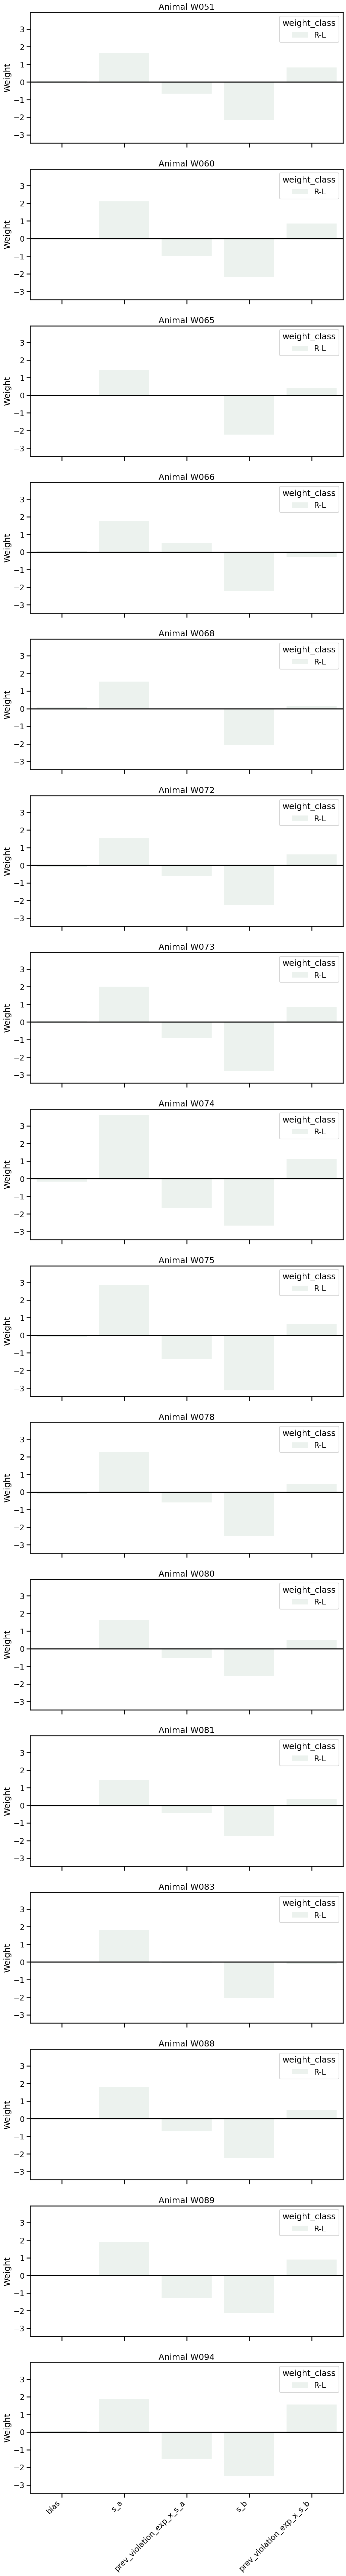

In [6]:
mv.plot_weights_by_animal(
    delta_weights_df, order=features_of_interest, color="mediumseagreen"
)

TODO: clean up the following into a function and save out? 

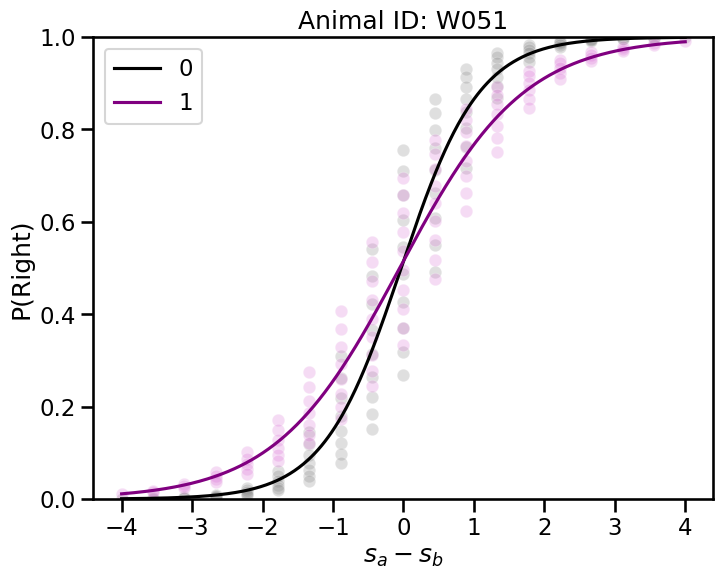

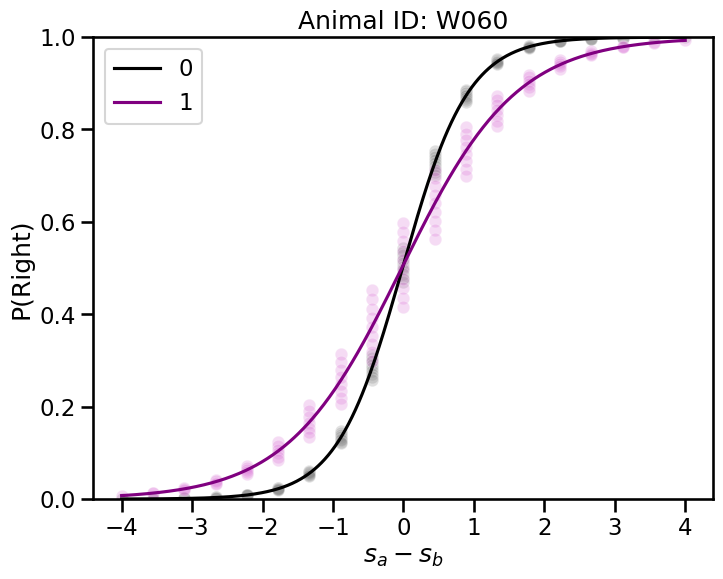

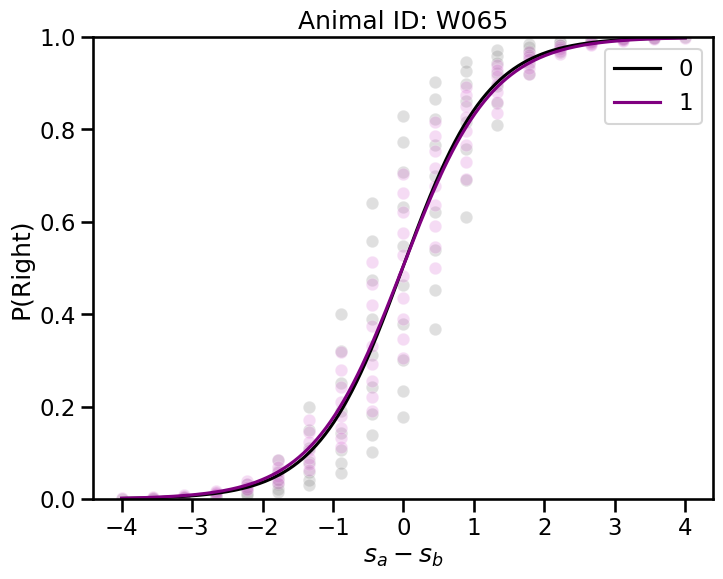

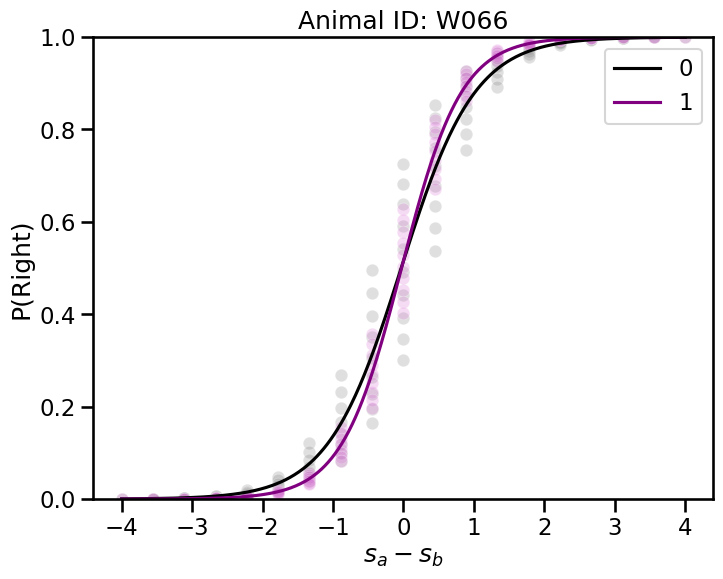

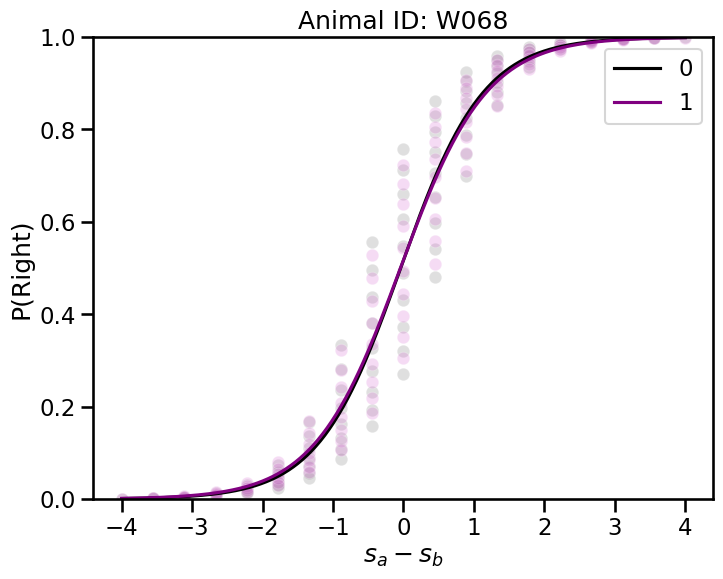

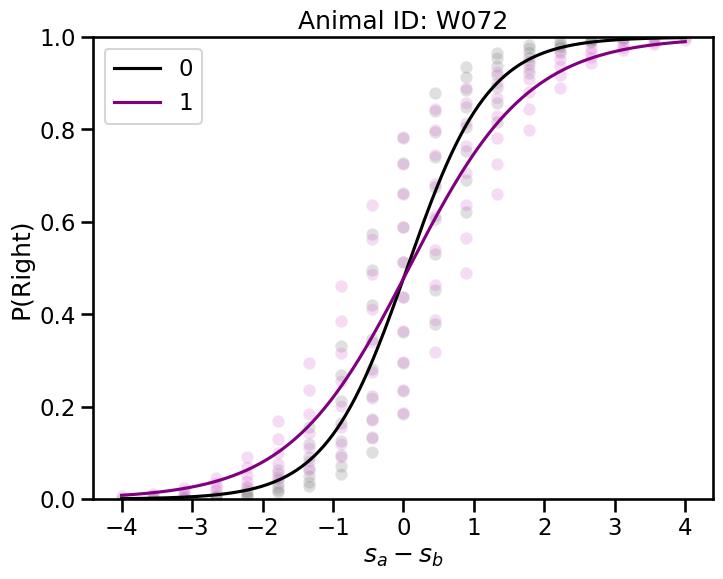

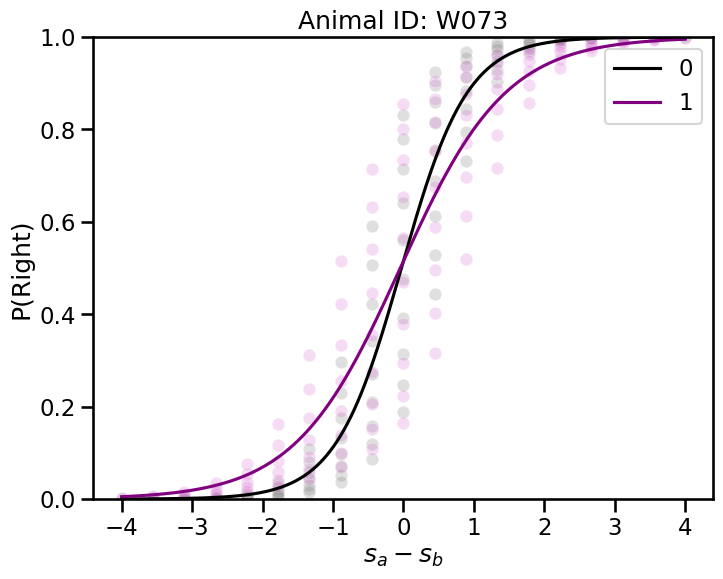

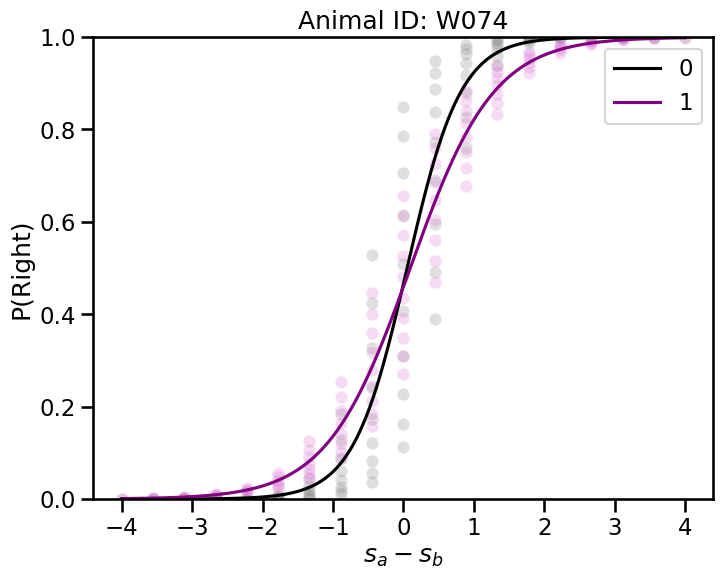

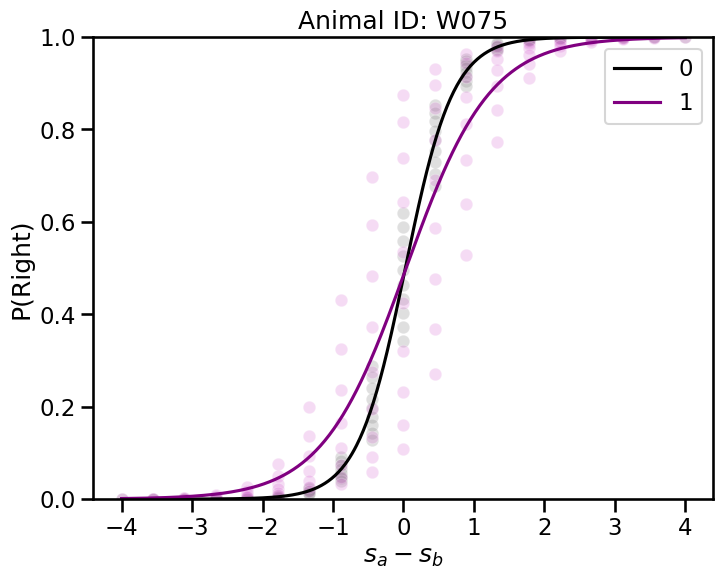

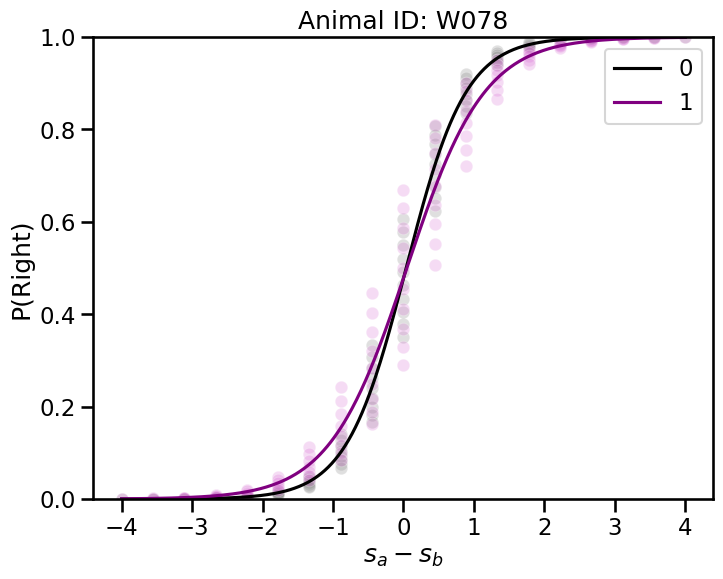

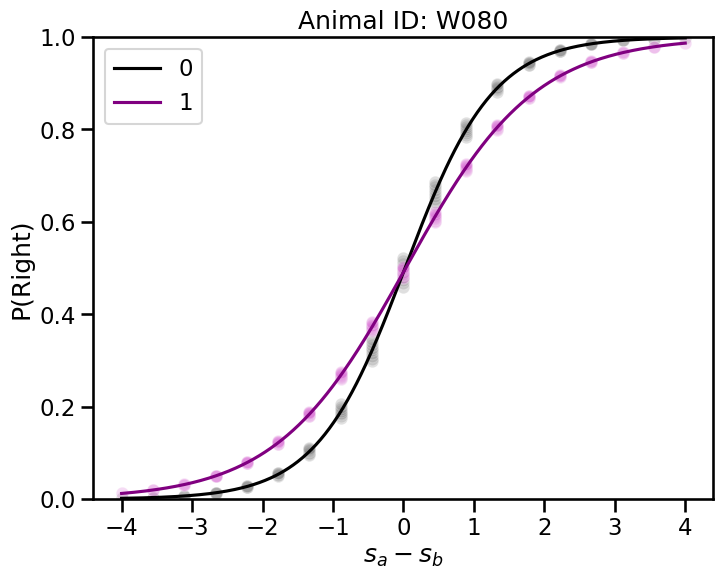

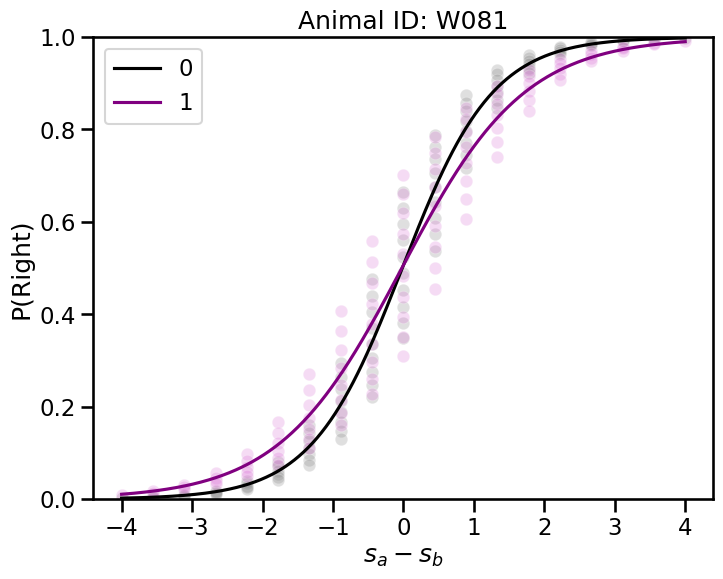

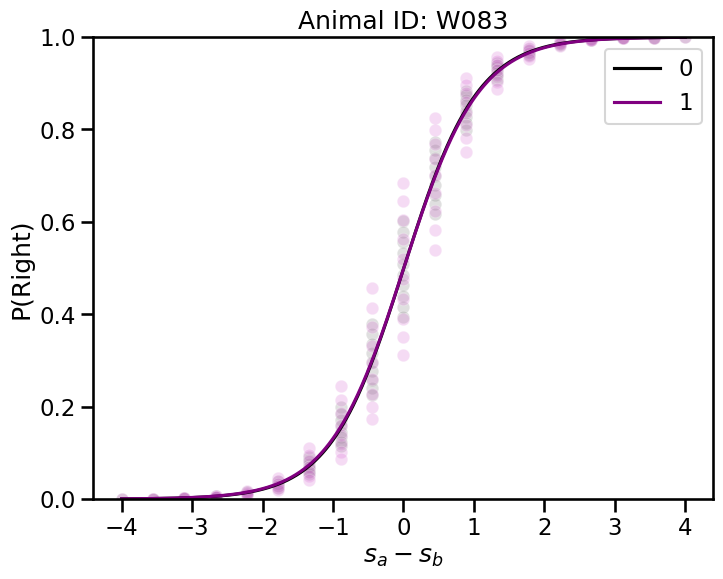

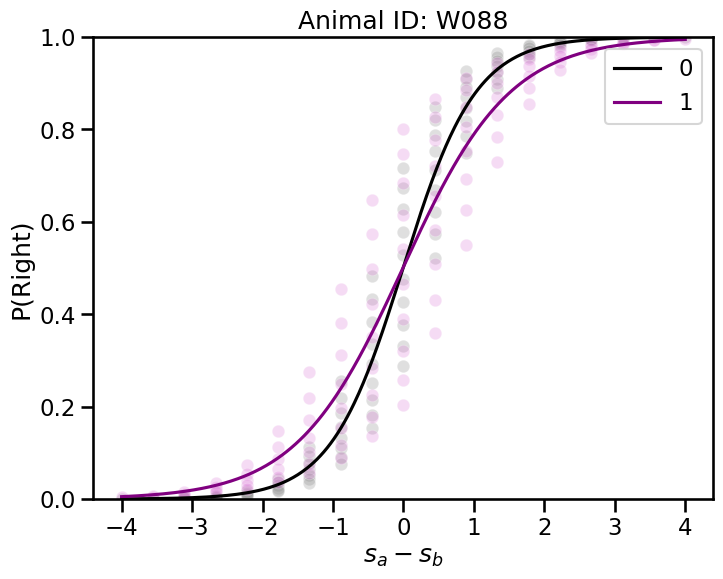

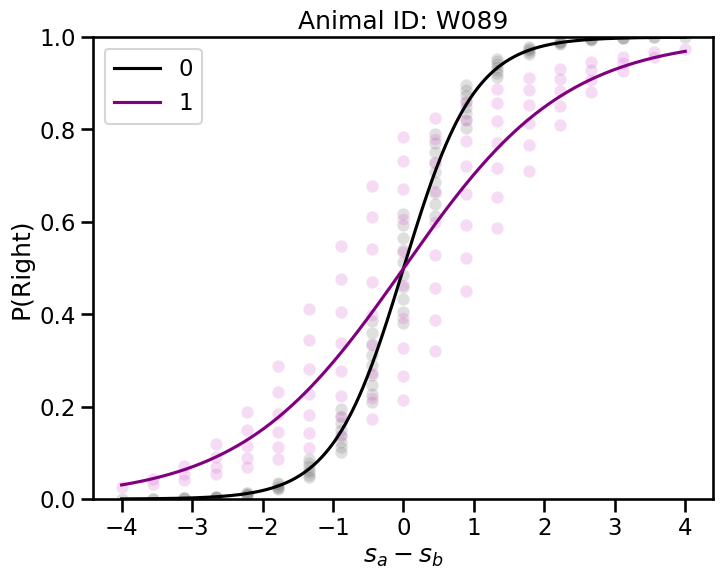

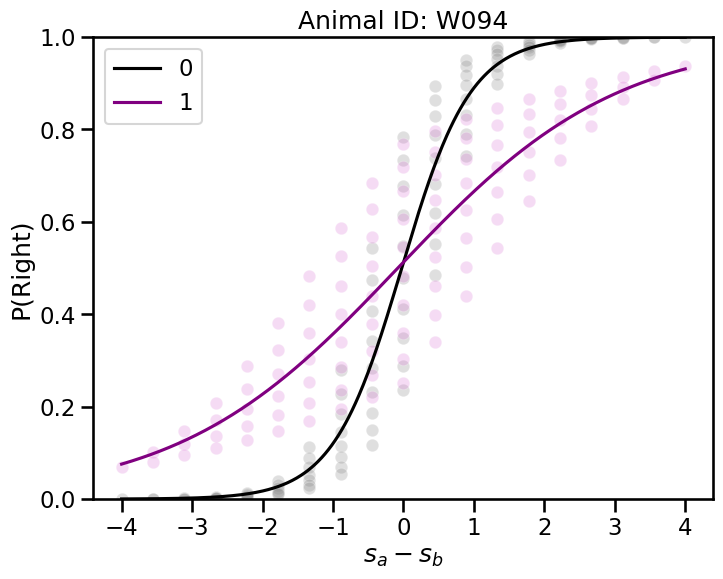

In [7]:
from multiglm.utils.psychometrics import *

X_enhanced = generate_x_data()
# List to collect fit results
fit_results = []
psych_results = []

# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    fig, ax = plt.subplots(figsize=(8, 6))

    for filter_val in [0, 1]:
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        fit_results.append(
            {
                "animal_id": animal_id,
                "filter": "on" if filter_val else "off",
                "alpha": params[0],
                "beta": params[1],
            }
        )

        # Plot the results
        sns.scatterplot(
            x=deltax,
            y=ys,
            ax=ax,
            alpha=0.25,
            color="orchid" if filter_val else "gray",
        )
        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=filter_val,
            color="purple" if filter_val else "black",
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
fit_results_df = pd.DataFrame(fit_results)
psych_results_df = pd.DataFrame(psych_results)

# Optional: Save fit results to a file
# fit_results_df.to_csv('fit_results.csv', index=False)

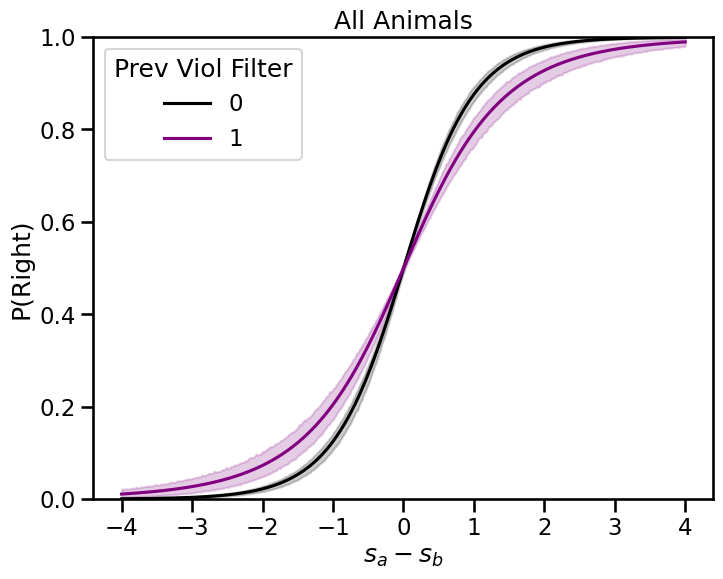

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=psych_results_df,
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_val",
    hue_order=[0, 1],
    palette=["black", "purple"],
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()

### With 75% interval etc.

In [16]:
prev_violation_df = filtered_prev_violation_df.copy()

summary_df = (
    prev_violation_df.groupby("animal_id").prev_violation_exp.median().reset_index()
).rename(columns={"prev_violation_exp": "median_prev_viol_exp"})


# add the mean of the filtered previous violation history
summary_df["mean_prev_viol_exp"] = summary_df["animal_id"].map(
    prev_violation_df.groupby("animal_id").prev_violation_exp.mean()
)

summary_df["prev_violation_tau"] = summary_df["animal_id"].map(
    prev_violation_df.groupby("animal_id").prev_violation_tau.max()
)

summary_df["quartile_25_prev_viol_exp"] = summary_df["animal_id"].map(
    prev_violation_df.groupby("animal_id").prev_violation_exp.quantile(0.25)
)

summary_df["quartile_75_prev_viol_exp"] = summary_df["animal_id"].map(
    prev_violation_df.groupby("animal_id").prev_violation_exp.quantile(0.75)
)

# summary_df["session_avg_viol_rate"] = summary_df["animal_id"].map(
#     viol_iti_df.groupby(["animal_id", "session"])
#     .violation.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .violation.mean()
# )

# summary_df["session_avg_hit_rate"] = summary_df["animal_id"].map(
#     viol_iti_df.groupby(["animal_id", "session"])
#     .hit.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .hit.mean()
# )
summary_df.head()

,animal_id,median_prev_viol_exp,mean_prev_viol_exp,prev_violation_tau,quartile_25_prev_viol_exp,quartile_75_prev_viol_exp
0,W051,0.039773,0.134658,2.0,0.000000,0.240270
1,W060,0.032517,0.133873,2.0,0.000000,0.234122
2,W065,0.173687,0.250540,2.0,0.032517,0.408101
3,W066,0.290249,0.306808,25.0,0.217197,0.378051
4,W068,0.312532,0.321435,40.0,0.216918,0.414695


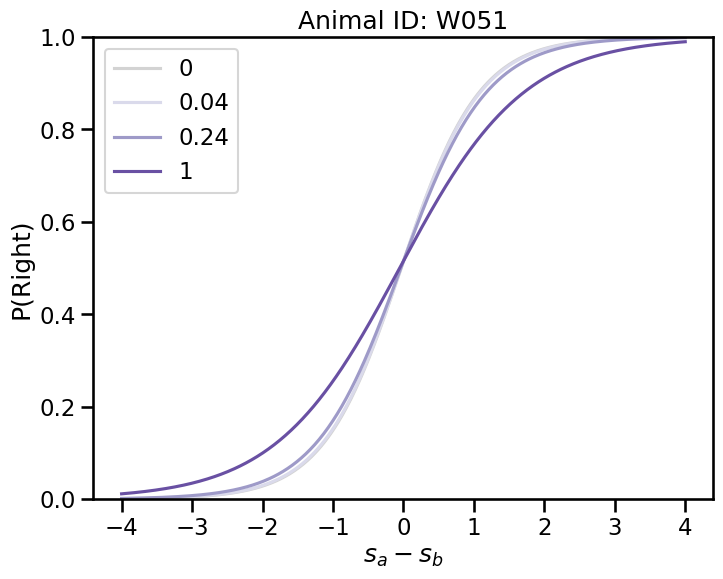

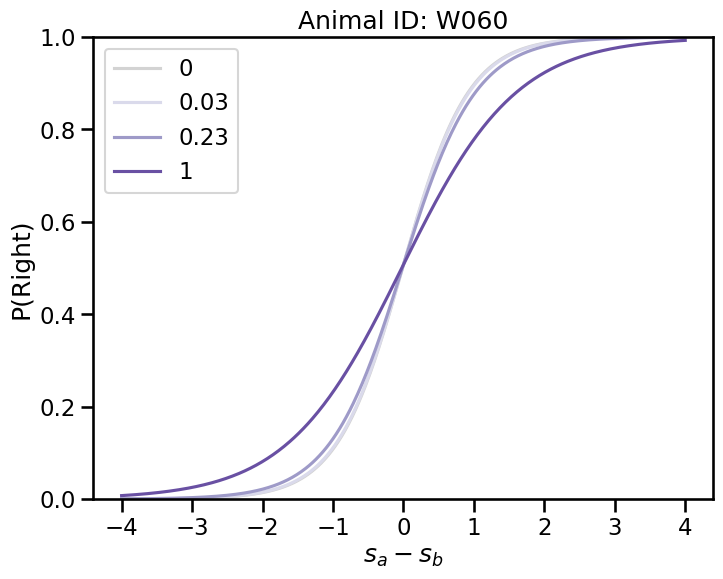

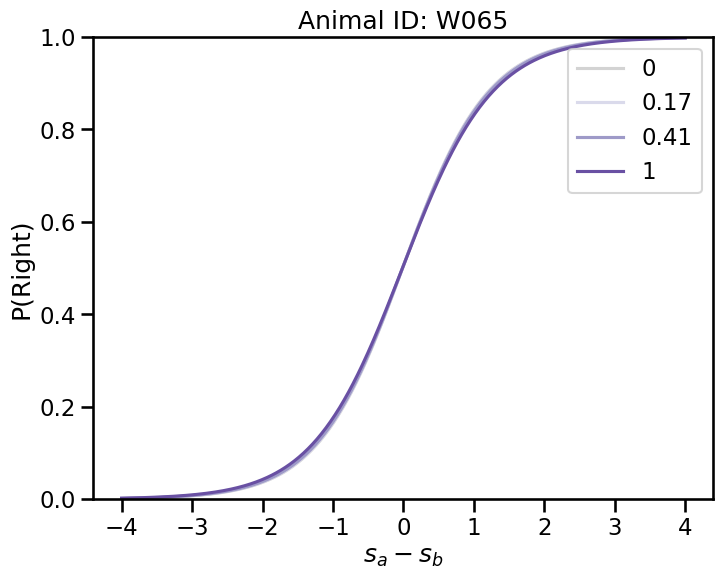

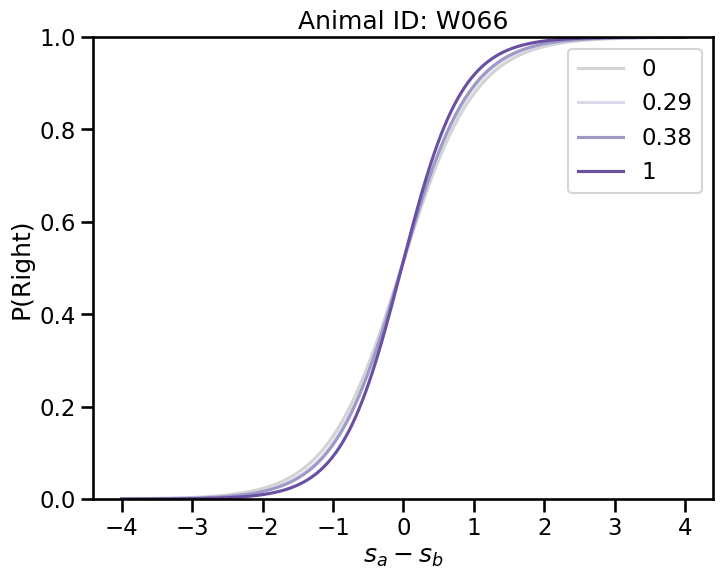

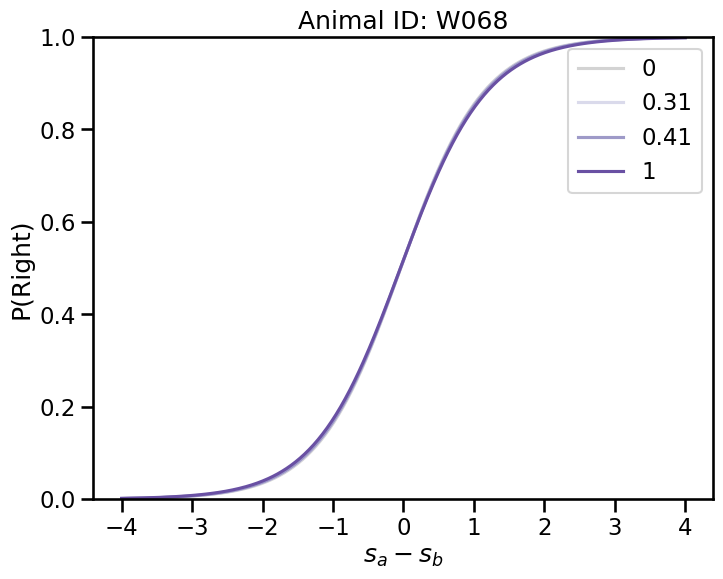

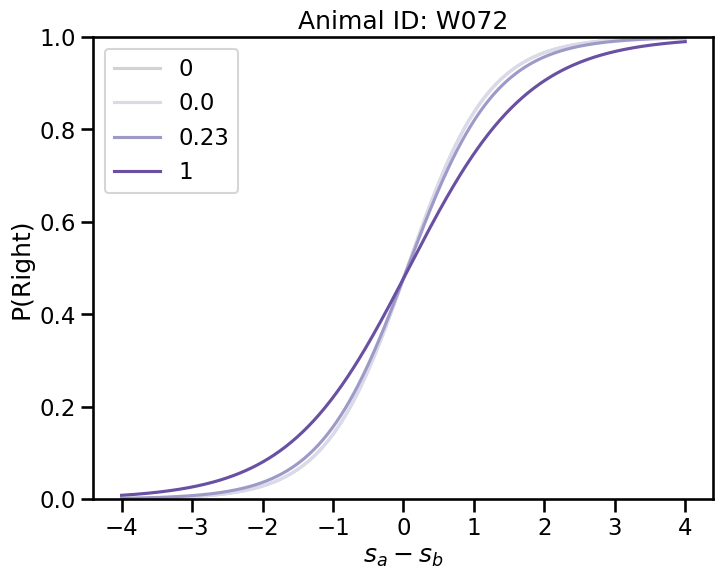

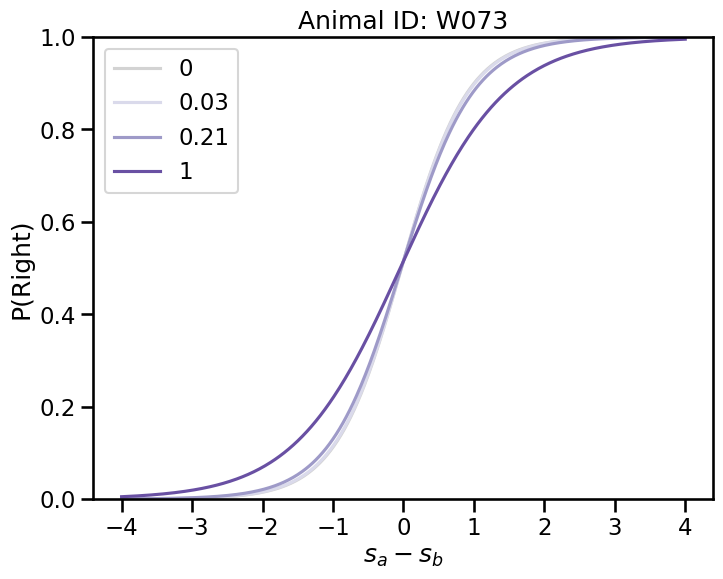

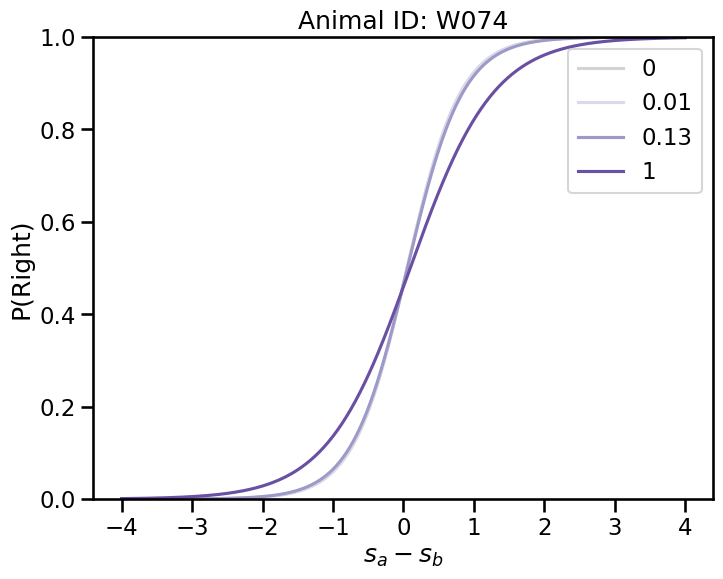

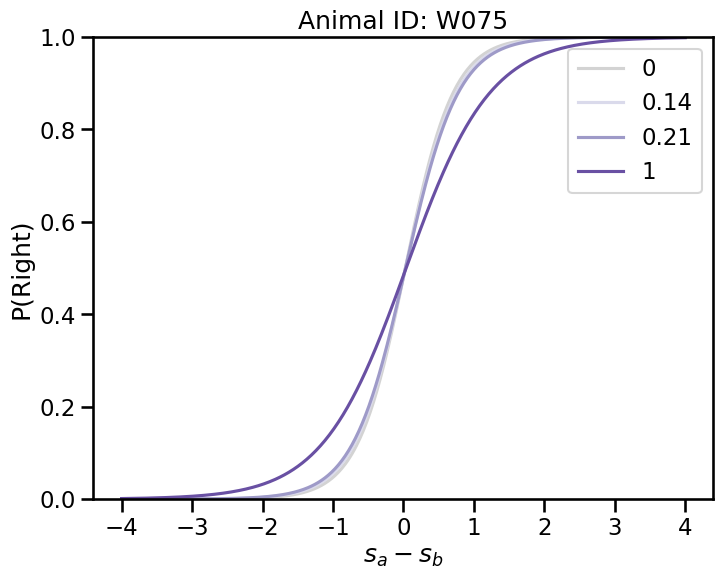

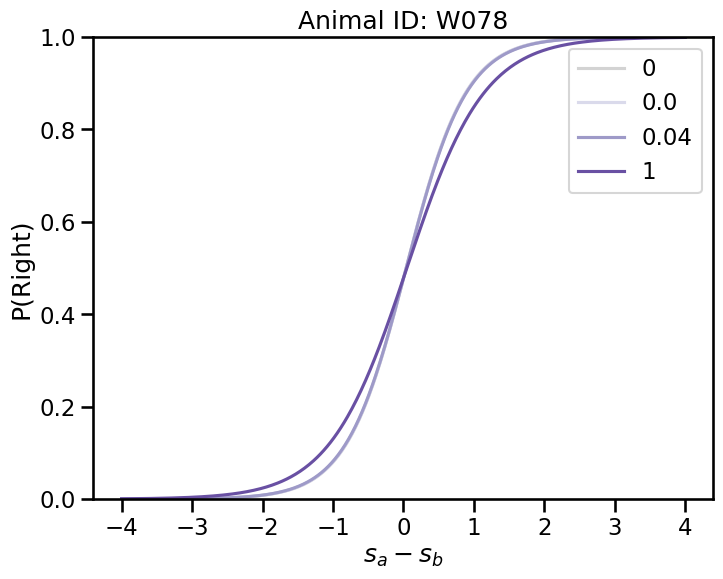

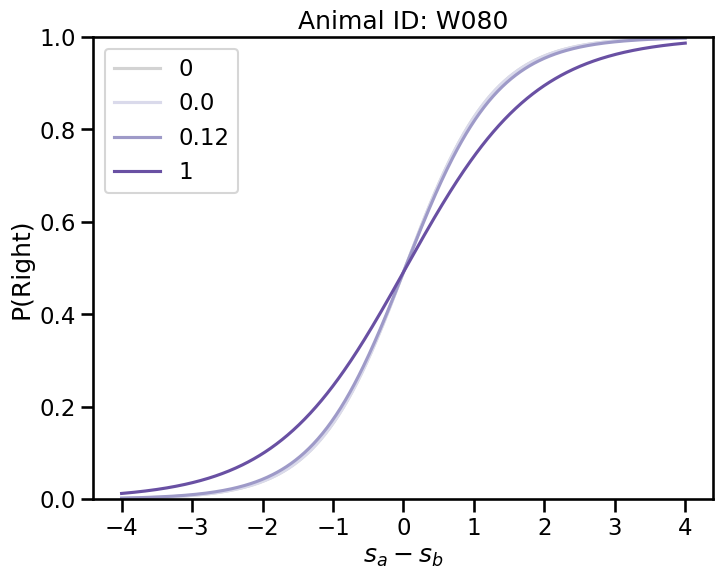

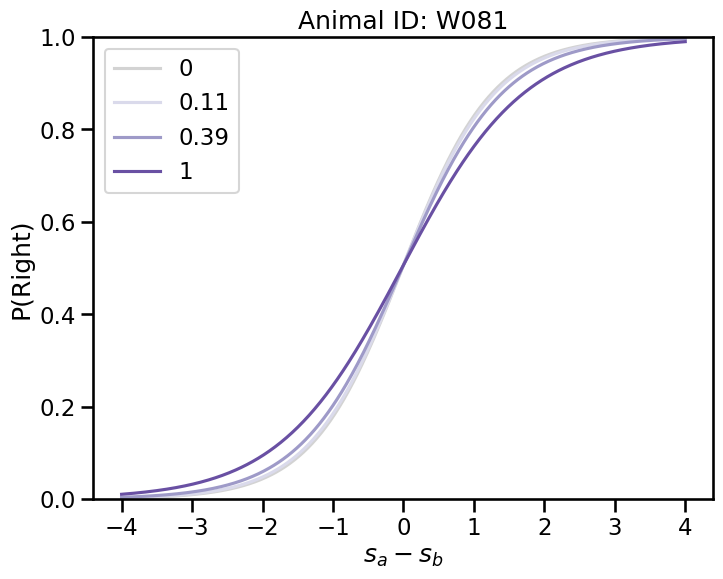

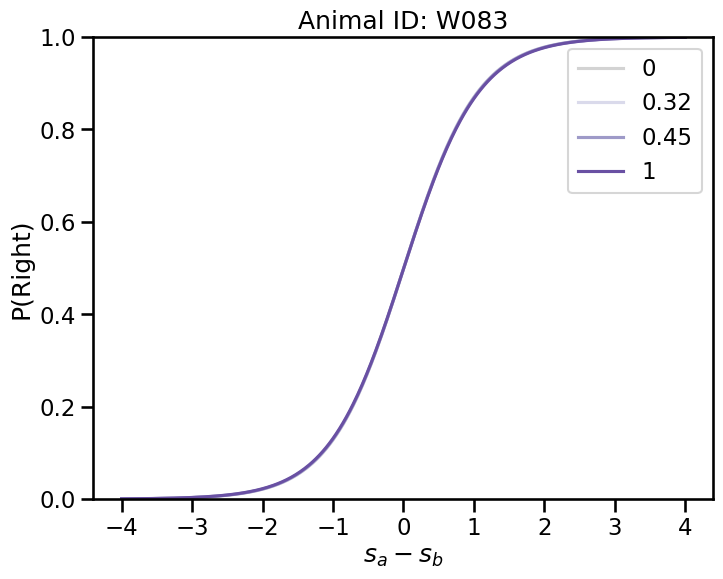

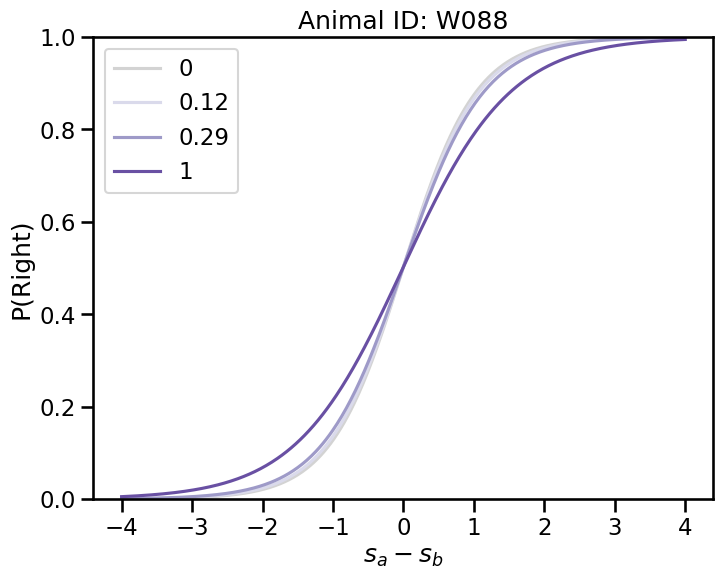

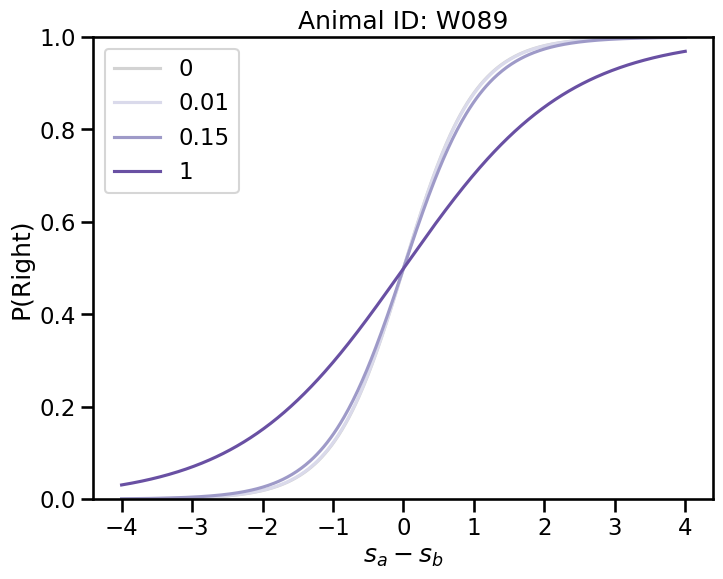

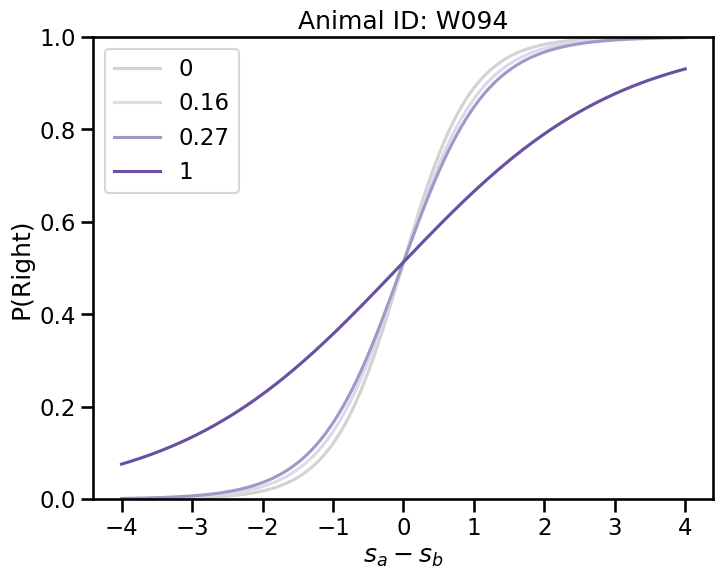

In [18]:
# List to collect fit results
full_fit_results = []
full_psych_results = []
psych_pallette = ["lightgray"] + [x for x in sns.color_palette("Purples", 3)]
filter_type = ["min (0)", "median", "75%", "max (1)"]
# Loop over each unique animal

for animal_id in delta_weights_df["animal_id"].unique():
    sub_df = delta_weights_df.query(f"animal_id == '{animal_id}'")

    meidan_filter_val = summary_df.query("animal_id == @animal_id")[
        "median_prev_viol_exp"
    ].values[0]

    quartile_75_filter_val = summary_df.query("animal_id == @animal_id")[
        "quartile_75_prev_viol_exp"
    ].values[0]

    fig, ax = plt.subplots(figsize=(8, 6))

    for idx, filter_val in enumerate([0, meidan_filter_val, quartile_75_filter_val, 1]):
        # Simulate the psychometric data
        deltax, ys = simulate_psych(sub_df, X_enhanced, filter_val)

        # Fit the psychometric function
        params, covariance = fit_psych(deltax, ys)

        # Collect the results
        full_fit_results.append(
            {
                "animal_id": animal_id,
                "filter": filter_val,
                "alpha": params[0],
                "beta": params[1],
            }
        )

        x_vals = np.linspace(deltax.min(), deltax.max(), 500)
        fitted_ys = sigmoid_for_curve_fit(x_vals, *params)

        full_psych_results.extend(
            {
                "animal_id": animal_id,
                "delta_stim": x_val,
                "p_right": y_val,
                "filter_val": filter_val,
                "filter_type": filter_type[idx],
            }
            for x_val, y_val in zip(x_vals, fitted_ys)
        )
        sns.lineplot(
            x=x_vals,
            y=fitted_ys,
            ax=ax,
            label=np.round(filter_val, 2),
            color=psych_pallette[idx],
        )

    ax.set_title(f"Animal ID: {animal_id}")
    ax.set_xlabel("$s_a - s_b$")
    ax.set_ylabel("P(Right)")
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

# Create a DataFrame from the collected fit results
full_fit_results_df = pd.DataFrame(full_fit_results)
full_psych_results_df = pd.DataFrame(full_psych_results)

In [ ]:
full_psych_results_df.filter_type.unique()

array(['min (0)', 'median', '75%', 'max (1)'], dtype=object)

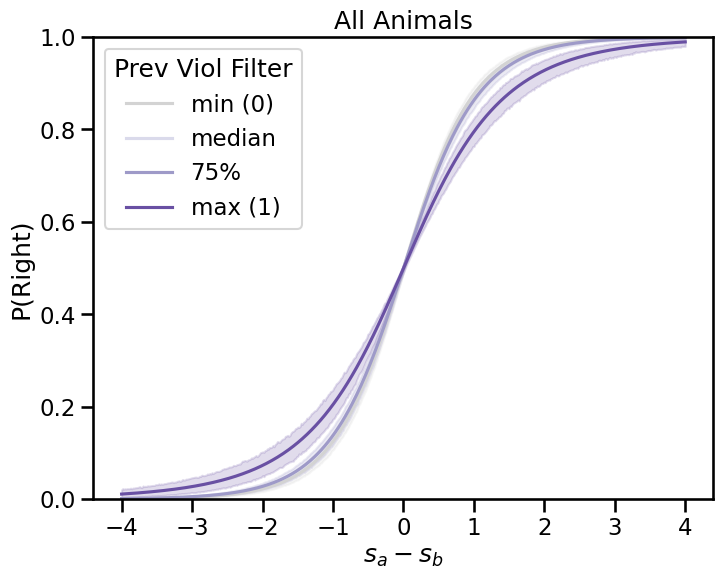

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=full_psych_results_df.query("filter_type != 'median'"),
    x="delta_stim",
    y="p_right",
    ax=ax,
    hue="filter_type",
    hue_order=filter_type,
    palette=psych_pallette,
    # errorbar=None,
)

ax.set_title(f"All Animals")
ax.set_xlabel("$s_a - s_b$")
ax.set_ylabel("P(Right)")
ax.set_ylim(0, 1)
ax.legend(title="Prev Viol Filter", loc="upper left")
plt.show()